In [ ]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# %matplotlib widget
basePath = "./sims.TNG/TNG50-1/output"
import tqdm
import gc
import os

In [ ]:
Snapshot_Init = 71
Snapshot_End = 99
Lbsg_Indcies_Array = np.array(
    [117251, 300903, 324123, 329508, 382215,
        400973, 419618, 457431, 460722, 490814]
)

h = 0.6774  # km/Mpc

m_dm = 4.5e-5  # E10M_Sum
m_dm_h = m_dm * h

Critial_Density = 1.27e-8  # E10M_Sum/kpc^3
Critial_Density_h = Critial_Density / h**2  # E10M_Sum/(kpc/h)^3

In [ ]:
Similiar_Stellar_Mass_Indices=np.load('./stellar_mass_indices.npy')

In [9]:
def HI_Radius_90_Calculation_At_99(Subhalo_Id):
    max_iter=100
    precension=1
    left = 0
    right=500

    subhalo_data_dict = il.groupcat.loadSingle(basePath,99,-1,Subhalo_Id)

    subhalo_comoving_position_floatarray = subhalo_data_dict['SubhaloPos']

    gas_data_dict=il.snapshot.loadSubhalo(basePath,99,Subhalo_Id,'gas',fields=['Coordinates','Masses','NeutralHydrogenAbundance'])
    
    if len(gas_data_dict)==1: return 0

    gas_data_dict['Masses']=gas_data_dict['Masses']*gas_data_dict['NeutralHydrogenAbundance']

    gas_mass_90=gas_data_dict['Masses'].sum()*0.9

    for epoch in range(max_iter):
        mid=(left+right)/2
        
        mass_in=Baryon_Mass_Within_Given_Radius(subhalo_comoving_position_floatarray,mid,gas_data_dict['Coordinates'],gas_data_dict['Masses'])

        if mass_in > gas_mass_90: right=mid

        else: left=mid

        if abs(right-left)<precension or epoch == max_iter:
            R_90_Com_Float = (left + right) / 2
            break

    del max_iter,precension,left,right,subhalo_data_dict,subhalo_comoving_position_floatarray,gas_data_dict,gas_mass_90

    return R_90_Com_Float

def Stellar_Radius_90_Calculation_At_99(Subhalo_Id):
    max_iter=100
    precension=1
    left = 0
    right=500

    subhalo_data_dict = il.groupcat.loadSingle(basePath,99,-1,Subhalo_Id)

    subhalo_comoving_position_floatarray = subhalo_data_dict['SubhaloPos']

    stellar_data_dict=il.snapshot.loadSubhalo(basePath,99,Subhalo_Id,'stellar',fields=['Coordinates','Masses'])
    
    if len(stellar_data_dict)==1: return 0

    stellar_mass_90=stellar_data_dict['Masses'].sum()*0.9

    for epoch in range(max_iter):

        mid=(left+right)/2
        mass_in=Baryon_Mass_Within_Given_Radius(subhalo_comoving_position_floatarray,mid,stellar_data_dict['Coordinates'],stellar_data_dict['Masses'])

        if mass_in > stellar_mass_90: right=mid

        else: left=mid

        if abs(right-left)<precension or epoch == max_iter:
            R_90_Com_Float = (left + right) / 2
            break

    del max_iter,precension,left,right,subhalo_data_dict,subhalo_comoving_position_floatarray,stellar_data_dict,stellar_mass_90

    return R_90_Com_Float



def Baryon_Mass_Within_Given_Radius(Galaxy_Center_FloatArray,Mass_Radius_Float,Particle_Coordinates_FloatArray,Particle_Masses_FloatArray):
    dist_to_com_floatarray = np.sqrt(np.sum((Particle_Coordinates_FloatArray - Galaxy_Center_FloatArray)**2, axis=1))
    within_radius_indices_intarray = np.where(dist_to_com_floatarray <= Mass_Radius_Float)[0]
    Total_Mass_Within_Radius_Float = np.sum(Particle_Masses_FloatArray[within_radius_indices_intarray])
    
    del dist_to_com_floatarray,within_radius_indices_intarray
    
    return Total_Mass_Within_Radius_Float

def Total_Mass_Type_Within_Given_Radius(Galaxy_Center_FloatArray,Mass_Radius_Float,Data_Dict):
    
    mass_within_radius=Baryon_Mass_Within_Given_Radius(Galaxy_Center_FloatArray,Mass_Radius_Float,Data_Dict['Coordinates'],Data_Dict['Masses'])
    
    return mass_within_radius

def Calculate_Radius_Ratio(Subhalo_Id):
    R_HI=HI_Radius_90_Calculation_At_99(Subhalo_Id)
    R_Stellar=Stellar_Radius_90_Calculation_At_99(Subhalo_Id)

    if R_HI * R_Stellar:
        return R_HI/R_Stellar

    else: return -1

In [10]:
ratio_list=list()
for subhalo_id in tqdm.tqdm(Similiar_Stellar_Mass_Indices):
    ratio_list.append(Calculate_Radius_Ratio(subhalo_id))

ratio_array=np.array(ratio_list)
np.save('./ratio.npy',ratio_array)

100%|██████████| 2602/2602 [2:57:28<00:00,  4.09s/it]  


Text(0.5, 1.0, 'Ratio Distribution')

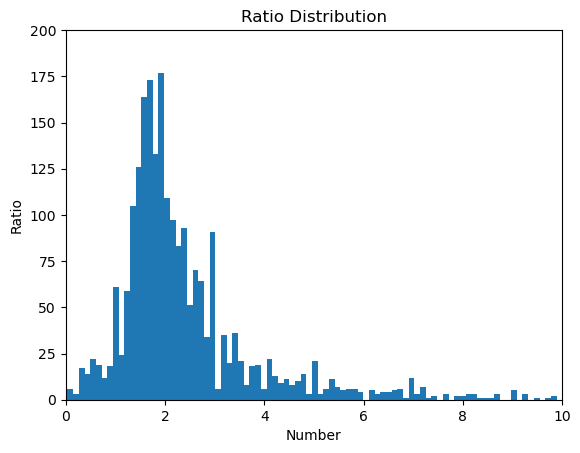

In [35]:
plt.hist(ratio_array,bins=1000)
plt.xlim([0,10])
plt.ylim([0,200])
plt.xlabel('Number')
plt.ylabel('Ratio')
plt.title('Ratio Distribution')

In [23]:
np.where(ratio_array==-1)[0].shape

(303,)

In [20]:
ratio_array.max()

113.66666666666667

In [29]:
data=il.groupcat.loadSubhalos(basePath,99,['SubhaloMass'])

In [34]:
np.where(data>50)[0].shape

(324,)

In [ ]:
Calculate_Radius_Ratio()